In [201]:
import requests
import json
import time
from datetime import date
from datetime import datetime
from helpers.history_fetcher import HistoryFetcher
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdelt # pip install gdelt
import folium
import os
from tqdm import tqdm_notebook # conda install tqdm
import operator
from helpers.wiki_helpers import get_stability_for_country, make_folium_map, wiki_change_factor

import warnings
warnings.filterwarnings('ignore')

import itertools

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Gather GDELT data
#### EXECUTE ONLY ON THE SERVER (memory issues)

In [ ]:
### this code is executed on the big server to obtain the results from 2011 to 2018 divided into 3 files per year
### for size.

import numpy as np
import pandas as pd
import gdelt # pip install gdelt
import gc

gd1 = gdelt.gdelt(version=1)
for i in range(11, 18):
    print('year : ', i , 1)
    results = gd1.Search(['20'+str(i)+' January 01','20'+str(i)+' May 01'],table='events')
    cols_to_keep = ['SQLDATE','ActionGeo_CountryCode','ActionGeo_Type' ]
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_20'+str(i)+'_1.pckl')
    del results
    gc.collect()
    print('year : ', i , 2)
    results = gd1.Search(['20'+str(i)+' May 01','20'+str(i)+' August 01'],table='events')
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_20'+str(i)+'_2.pckl')
    del results
    gc.collect()
    print('year : ', i , 3)
    if(i != 17):
        results = gd1.Search(['20'+str(i)+' August 01','20'+str(i+1)+' January 01'],table='events')
    else:
        results = gd1.Search(['20'+str(i)+' August 01','20'+str(i)+' December 01'],table='events')
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_20'+str(i)+'_3.pckl')
    del results
    gc.collect()

### Process GDELT Data (aggregate) 
#### EXECUTE ONLY ON THE SERVER (memory issues)

In [ ]:
from os import listdir
from os.path import isfile, join
import gc

def process_files():
    onlyfiles = [f for f in listdir('.') if isfile(join('.', f))]
    
    grouped = pd.DataFrame()
    for i, file in enumerate(onlyfiles):
        print('processing ', file)
        gc.collect()
        try:
            data = pd.read_pickle(file)
            data['Counter'] = 1.0
            data = data[['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type', 'Counter']]
        except:
            continue;
        grouped = grouped.append([data.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()])
        pd.to_pickle(grouped, 'processed/'+str(i)+'.pckl')
        del data

### Show the gathered data

In [172]:
CAMEO_event_dic = {1:'MAKE PUBLIC STATEMENT', 
                   2:'APPEAL', 
                   3:'EXPRESS INTENT TO COOPERATE', 
                   4:'CONSULT', 
                   5:'ENGAGE IN DIPLOMATIC COOPERATION', 
                   np.NaN:'',
                   0:'UNKNOWN'}


aggregated_gdelt = pd.read_pickle('data/23.pckl')
# clean the dataframe
aggregated_gdelt.reset_index(inplace=True)
# change names
aggregated_gdelt['ActionGeo_Type'] = aggregated_gdelt['ActionGeo_Type'].map(CAMEO_event_dic)
aggregated_gdelt.sort_values('SQLDATE', inplace=True)
# take only values above 2011
aggregated_gdelt = aggregated_gdelt[aggregated_gdelt['SQLDATE'] > 20110101]
# convert to Timestamp (takes lots of time)
aggregated_gdelt['SQLDATE'] = aggregated_gdelt['SQLDATE'].apply(lambda x: str(x) )
aggregated_gdelt['SQLDATE2'] = aggregated_gdelt['SQLDATE'].apply(lambda x: pd.Timestamp(x).to_pydatetime())
pd.to_pickle(aggregated_gdelt, 'data/aggregated_gdelt.pckl')
aggregated_gdelt.head(20)

,SQLDATE,ActionGeo_CountryCode,ActionGeo_Type,Counter,SQLDATE2
148228,20110102,RQ,MAKE PUBLIC STATEMENT,82.0,2011-01-02
148190,20110102,OC,UNKNOWN,1.0,2011-01-02
148189,20110102,NZ,ENGAGE IN DIPLOMATIC COOPERATION,7.0,2011-01-02
148188,20110102,NZ,CONSULT,165.0,2011-01-02
148187,20110102,NZ,MAKE PUBLIC STATEMENT,72.0,2011-01-02
148186,20110102,NZ,UNKNOWN,2.0,2011-01-02
148185,20110102,NU,CONSULT,1.0,2011-01-02
148184,20110102,NU,MAKE PUBLIC STATEMENT,6.0,2011-01-02
148183,20110102,NU,UNKNOWN,1.0,2011-01-02
148182,20110102,NS,CONSULT,2.0,2011-01-02


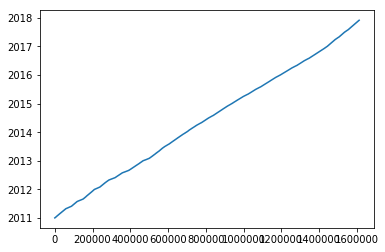

In [159]:
dates = aggregated_gdelt['SQLDATE'].values
cntr_codes = aggregated_gdelt['ActionGeo_CountryCode'].values
types = aggregated_gdelt['ActionGeo_Type'].values


plt.plot(sorted(dates))
plt.show()

In [171]:
aggregated_gdelt.dtypes

SQLDATE                    int64
ActionGeo_CountryCode     object
ActionGeo_Type            object
Counter                  float64
dtype: object

In [168]:
dates = aggregated_gdelt['SQLDATE']
dates.apply(lambda x: x.to_pydatetime())
dates.dtypes

dtype('<M8[ns]')

In [199]:
def get_country_values(cntr_code, normalize=True):
    values_to_plot = aggregated_gdelt[ (aggregated_gdelt['ActionGeo_CountryCode'] == cntr_code)];
    values_to_plot['ActionGeo_Type'] = 0;
    values_to_plot.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()
    values_to_plot.reset_index(inplace=True)
    if(normalize):
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']/ values_to_plot['Counter'].mean()
    else:
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']
    return x.values,y.values


def plot_aggregated_events_and_wiki(cntr_code, cntr_full_name, normalize=False):
    
    
    # Fetches Ukraine's wikipedia page history
    history_fetcher = HistoryFetcher(cntr_full_name)
    response = history_fetcher.get_history('20110101000000', '20171201000000')
    
    print('got responses', len(response))

    # Keeps only the date field for each edit
    pl_edits_dates = list(map(lambda revision: revision['timestamp'], response))

    plt.clf()
    plt.figure(figsize = (20,10))
    
    values_to_plot = aggregated_gdelt[ (aggregated_gdelt['ActionGeo_CountryCode'] == cntr_code)];
    values_to_plot['ActionGeo_Type'] = 0;
    values_to_plot.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()
    values_to_plot.reset_index(inplace=True)
    if(normalize):
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']/ values_to_plot['Counter'].mean()
    else:
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']

    print('Doing hist1')
    plt.hist(x.values, weights=y.values,bins=1000, color='blue', alpha=0.5)
    print('Done')

    plt.xlabel('Date')
    if(normalize):
        plt.ylabel('Normalized to mean aggregated events')
    else:
        plt.ylabel('Aggregated events')
    plt.title('Events for '+cntr_code)
    
    plt.hold(True)
    
    print('Doing hist2')
    # Add historgram for the number of edits on ukraine's wikipedia page (normalized)
    plt.hist(pl_edits_dates, bins=1000, normed=True,color='blue',alpha=0.5, label='# of edits on Ukraine page')
    print('done')
    
    plt.show()


In [198]:
plot_aggregated_events_and_wiki('PL','Poland', normalize=True)

got responses 3263
Doing hist1
Done
Doing hist2


ValueError: could not convert string to float: '2017-10-30 06:57:26+00:00'

In [ ]:
plot_aggregated_events_and_wiki('FR','France', normalize=True)

In [202]:
# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('France')
response = history_fetcher.get_history('20110201000000', '20170430000000')

# Keeps only the date field for each edit
fr_edits_dates = list(map(lambda revision: revision['timestamp'], response))

# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
n_wiki, bins_wiki, patches_wiki = plt.hist(fr_edits_dates,\
                                           bins=79,\
                                           normed=True,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on Ukraine page')

fr_events_dates, _ = get_country_values('FR')
# Add histogram for the number of events (normalized)
n_event, bins_event, patches_event = plt.hist(fr_events_dates,\
                                              bins=79,\
                                              color='green',\
                                              normed=True,\
                                              alpha=0.5,\
                                              label='# events in Ukraine')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

ValueError: could not convert string to float: '2017-04-29 15:08:45+00:00'